In [1]:
from alf_utils import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Camera calibration

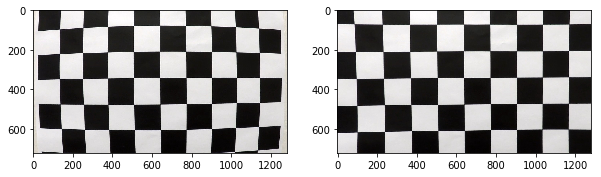

In [2]:
mtx, dist = undistort('camera_cal/')

img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(dst[:,:,::-1])

# Perspective Transform

In [3]:
# pts = np.array([[240,675],
#                 [550,475],
#                 [740,475],
#                 [1080,675]], dtype="float32")
pts = np.array([[180,720],
                [550,475],
                [740,475],
                [1160,720]], dtype="float32")
dst = np.array([[100,720],
                [100,0],
                [1180,0],
                [1180,720]], dtype="float32")

M = cv2.getPerspectiveTransform(pts, dst)
Minv = cv2.getPerspectiveTransform(dst, pts)

In [4]:
img = cv2.imread('test_images/straight_lines2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
warped = cv2.warpPerspective(undist, M, (1280, 720))

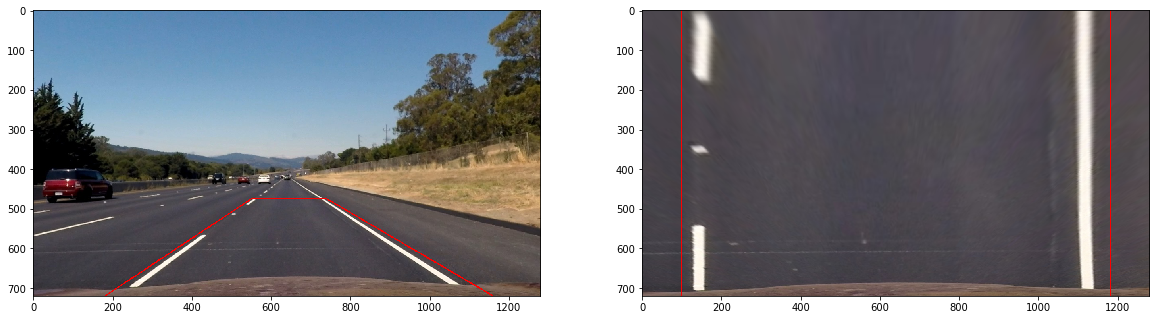

In [5]:
# _ = cv2.line(undist,(240,675),(550,475),(0,0,255),2)
# _ = cv2.line(undist,(550,475),(740,475),(0,0,255),2)
# _ = cv2.line(undist,(740,475),(1080,675),(0,0,255),2)
# _ = cv2.line(undist,(1080,675),(240,675),(0,0,255),2)
_ = cv2.line(undist,(180,720),(550,475),(0,0,255),2)
_ = cv2.line(undist,(550,475),(740,475),(0,0,255),2)
_ = cv2.line(undist,(740,475),(1160,720),(0,0,255),2)
_ = cv2.line(undist,(1160,720),(180,720),(0,0,255),2)


_ = cv2.line(warped,(100,720),(100,0),(0,0,255),2)
_ = cv2.line(warped,(1180,0),(1180,720),(0,0,255),2)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(undist[:,:,::-1])
plt.subplot(122)
plt.imshow(warped[:,:,::-1])

# Lane Edges

In [6]:
img = cv2.imread('test_images/test3.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
binary = lane_edges(undist)
imshape = binary.shape
vertices = np.array([[(150,imshape[0]),
                    (imshape[1]*.46,imshape[0]*.60),
                    (imshape[1]*.54,imshape[0]*.60),
                    (imshape[1]-150,imshape[0])]], dtype=np.int32)

roi_img = region_of_interest(binary, vertices)
binary_warped = cv2.warpPerspective(roi_img, M, (1280, 720))

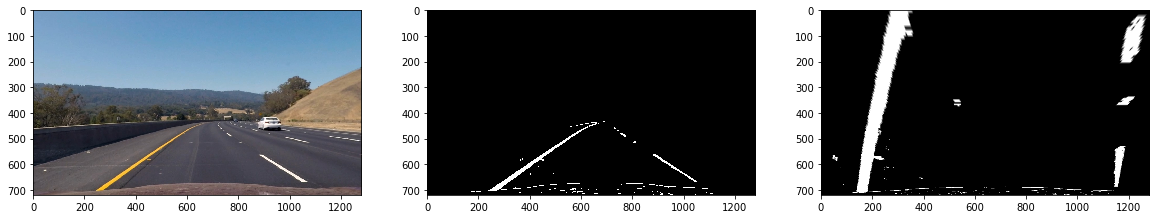

In [7]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(undist[:,:,::-1])
plt.subplot(132)
plt.imshow(roi_img, cmap='gray')
plt.subplot(133)
plt.imshow(binary_warped, cmap='gray')

# Polynomial Fit

In [8]:
left_fit, right_fit = lane_poly(binary_warped)

# Lane Points

In [9]:
left_fitx, right_fitx, ploty = lane_pts(binary_warped, left_fit, right_fit)

# Fill Lane

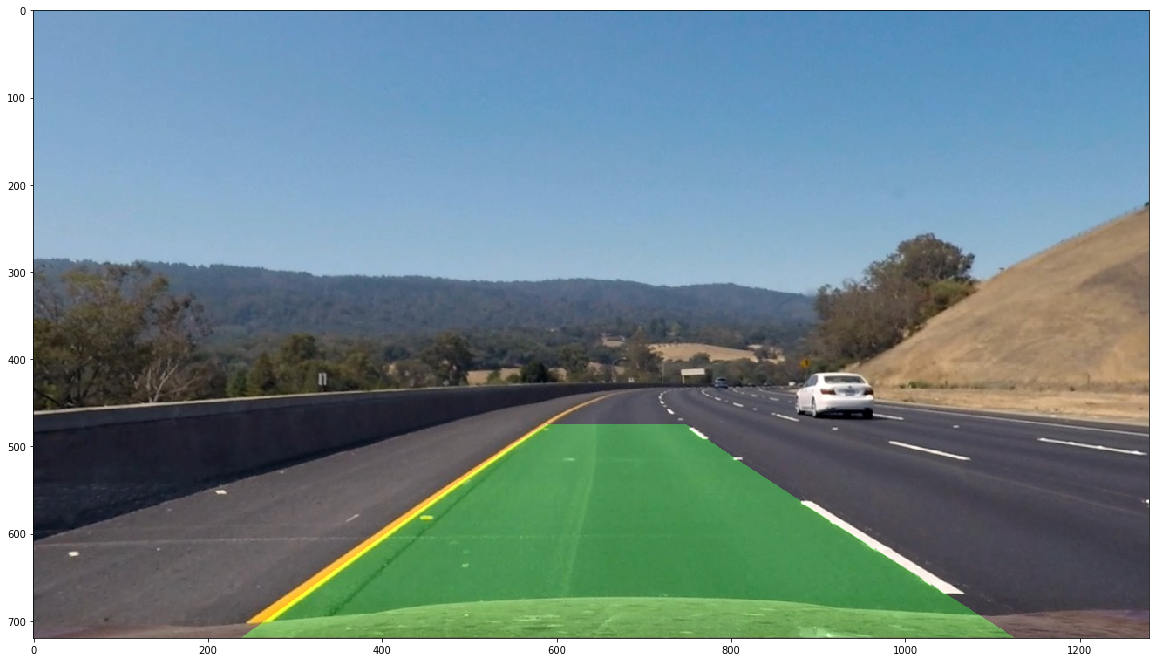

In [10]:
fill_img = fill_lane(undist, binary_warped, ploty, left_fitx, right_fitx, Minv)

plt.figure(figsize=(20,20))
plt.imshow(fill_img[:,:,::-1])

# Radius of Curvature

In [11]:
curverad = radius_of_curvature(binary_warped, left_fit, right_fit)
position = dist_from_center(binary_warped, left_fitx, right_fitx)

curvature_string = "Radius of curvature: %.2f m" % curverad
print(curvature_string)
offset_string = "Distance from center: %.2f m" % position
print(offset_string)


Radius of curvature: 1615.81 m
Distance from center: 0.07 m


# Pipeline

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def calc_lane_width(left_fitx, right_fitx):
    return np.mean(right_fitx - left_fitx)

def validate_lane_width(lw):
    global lane_width_history
    
    if len(lane_width_history)==0:
        lane_width_history.append(lw)
    elif ((lw / np.mean(lane_width_history)) < 0.9) | ((lw / np.mean(lane_width_history)) > 1.1):
        return False
    else:
        lane_width_history.append(lw)
    return True
        
def smooth_lane_fit(frames):
    global left_fit_history
    global right_fit_history
    
    i = len(left_fit_history)
    if i == 1:
        smooth_left_fit = left_fit_history[0]
        smooth_right_fit = right_fit_history[0]
    elif i < frames:
        smooth_left_fit = np.mean(left_fit_history[-i:], axis=0)
        smooth_right_fit = np.mean(right_fit_history[-i:], axis=0)
    else:
        smooth_left_fit = np.mean(left_fit_history[-frames:], axis=0)
        smooth_right_fit = np.mean(right_fit_history[-frames:], axis=0)
        
    return smooth_left_fit, smooth_right_fit

    
def process_image(image):
    global left_fit_history
    global right_fit_history
    global radius_history
    global center_history
        
    undist = cv2.undistort(image[:,:,::-1], mtx, dist, None, mtx)
    binary = lane_edges(undist)
    binary_warped = cv2.warpPerspective(binary, M, (1280, 720))
    
    if len(left_fit_history)==0:
        left_fit, right_fit = lane_poly(binary_warped)
    else:
        left_fit, right_fit = lane_poly_margin(binary_warped, left_fit_history[-1], right_fit_history[-1], margin=50)
        
    left_fitx, right_fitx, ploty = lane_pts(binary_warped, left_fit, right_fit)

    lane_width = calc_lane_width(left_fitx, right_fitx)   
    if validate_lane_width(lane_width):
        left_fit_history.append(left_fit)
        right_fit_history.append(right_fit)
        
    smooth_left_fit, smooth_right_fit = smooth_lane_fit(4)
    left_fitx, right_fitx, ploty = lane_pts(binary_warped, smooth_left_fit, smooth_right_fit)
    result = fill_lane(undist, binary_warped, ploty, left_fitx, right_fitx, Minv)
    
    curverad = radius_of_curvature(binary_warped, left_fit, right_fit)
    radius_history.append(curverad)
    if len(radius_history)<100:
        curverad = np.mean(radius_history)
    else:
        curverad = np.mean(radius_history[-100:])

    position = dist_from_center(binary_warped, left_fitx, right_fitx)
    center_history.append(position)
    if len(radius_history)<100:
        position = np.mean(center_history)
    else:
        position = np.mean(center_history[-100:])    

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, "Radius of curvature: {0:.2f}m".format(curverad), (75,100), font, 1., (0,0,0), 2, cv2.LINE_AA)
    cv2.putText(result, "Distance from center: {0:.2f}m".format(position), (75,150), font, 1., (0,0,0), 2, cv2.LINE_AA)
    
    return result[:,:,::-1]

In [14]:
left_fit_history = []
right_fit_history = []
lane_width_history = []
radius_history = []
center_history = []

test_output = 'project_video_out.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:52<00:00,  5.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 4min 18s, sys: 32.6 s, total: 4min 50s
Wall time: 3min 53s
